In [383]:
import json
import imageio
import numpy as np
import os
import re
from skimage import draw, io
import uuid

In [384]:
labelbox_json = json.load(open('./rocks.json'))
output_path = './output'

In [387]:
for rock in labelbox_json:
    image_name = rock['External ID']
    image_url = rock['Labeled Data']
    print("image_name: {}".format(image_name))
    print("image_url: {}".format(image_url))
    
    image = io.imread(image_url)
#     print(image.shape)
    height, width = image.shape[:2]
    
    labels = rock['Label']
    if labels == 'Skip':
        continue
        
    for label_name, label_polygons in labels.items():
        print(label_name)
#         mask = np.zeros([height, width, len(label_polygons)], dtype=np.uint8)
        
        for label_polygon in label_polygons:
            mask = np.zeros((height, width), dtype=np.uint8)
#             print(mask.shape)
            all_points_x = []
            all_points_y = []
            for coords in label_polygon:
                all_points_x.append(coords['x'])
                all_points_y.append(coords['y'])

#             print(all_points_x)
#             print(all_points_y)
            rr, cc = draw.polygon(all_points_y, all_points_x)
            
            mask[rr, cc] = 1
            mask = np.flipud(mask)
            print(mask)

            uuid_hex = uuid.uuid4().hex
            image_output_path = os.path.join(output_path, 'images', image_name + uuid_hex + '.png')
            imageio.imwrite(image_output_path, image)
            
            instance_mask_output_path = os.path.join(output_path, 'masks', image_name + uuid_hex + '.png')
            imageio.imwrite(instance_mask_output_path, mask)
            
    if 'Masks' in rock.keys():
        binary_masks = []
        for mask_name in rock['Masks'].keys():
            binary_masks.append({
                'Name': mask_name,
                'Url': rock['Masks'][mask_name]
            })
        print("{}, {}".format(image_name, binary_masks))
    print("")

image_name: rock-9.png
image_url: https://firebasestorage.googleapis.com/v0/b/labelbox-193903.appspot.com/o/cjg1w56dbv7pi0176bdq92mk7%2F846e3c81-6fa1-4ee7-b12c-8ec699ab6314%2Frock-9.png?alt=media&token=9d379666-b6d7-4ef1-a978-54e70d395dda
(800, 1294, 4)
Car
(800, 1294)
[1048, 1042, 1032, 1023, 1015, 1008, 1002, 996, 988, 984, 976, 968, 962, 956, 952, 945, 940, 929, 922, 912, 902, 894, 888, 878, 870, 859, 853, 845, 836, 827, 818, 810, 800, 791, 785, 779, 772, 764, 758, 750, 745, 738, 736, 730, 725, 725, 718, 715, 711, 707, 702, 699, 697, 695, 693, 689, 687, 684, 683, 682, 686, 688, 689, 691, 697, 702, 702, 704, 711, 717, 722, 728, 735, 741, 744, 748, 759, 768, 774, 782, 790, 798, 810, 819, 829, 834, 846, 856, 864, 872, 883, 893, 901, 911, 921, 932, 941, 952, 959, 968, 976, 984, 996, 1004, 1012, 1019, 1026, 1033, 1042, 1050, 1056, 1055]
[612, 607, 608, 607, 607, 605, 602, 600, 599, 598, 596, 597, 597, 595, 593, 592, 588, 585, 582, 580, 578, 576, 572, 571, 569, 568, 564, 559, 555, 553, 55

(800, 1294)
[661, 656, 652, 649, 643, 640, 637, 634, 628, 623, 616, 615, 612, 605, 600, 591, 586, 580, 571, 567, 567, 560, 552, 541, 536, 537, 547, 557, 567, 575, 578, 589, 594, 600, 609, 614, 619, 621, 622, 623, 630, 635, 640, 647, 652, 654, 659, 663]
[712, 705, 700, 690, 682, 676, 671, 665, 656, 646, 639, 628, 616, 608, 601, 592, 581, 575, 571, 564, 557, 550, 547, 549, 545, 541, 543, 544, 545, 555, 566, 569, 580, 590, 595, 603, 611, 621, 629, 637, 641, 653, 660, 666, 674, 683, 691, 697]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(800, 1294)
[498, 491, 480, 468, 462, 460, 458, 456, 455, 455, 454, 454, 454, 452, 450, 447, 445, 444, 444, 450, 453, 453, 451, 448, 444, 444, 447, 447, 444, 444, 443, 439, 437, 435, 435, 432, 428, 424, 418, 410, 401, 392, 385, 380, 371, 360, 350, 341, 335, 328, 318, 311, 301, 294, 285, 278, 273, 267, 263, 259, 260, 255, 249, 249, 245, 245, 246, 248, 250, 254, 257, 259, 263, 266, 271

(378, 867)
[514, 514, 515, 515, 516, 515, 519, 520, 519, 518, 518, 518, 516, 516, 513, 508, 508, 512, 513, 513, 512, 510, 509, 509, 509, 512, 510, 508, 506, 506, 506, 504, 501, 498, 495, 495, 496, 503, 512, 511, 508, 508, 510, 514, 515, 517, 518, 515, 518, 520, 520, 519, 520, 525, 525, 525, 525, 525, 526, 526, 525, 524, 522, 520, 521, 522, 522, 521, 521, 521, 520]
[323, 315, 303, 295, 285, 275, 267, 258, 249, 242, 233, 220, 212, 204, 199, 197, 192, 187, 180, 172, 162, 156, 150, 145, 136, 128, 119, 115, 108, 101, 92, 87, 77, 67, 59, 46, 40, 40, 42, 59, 67, 73, 82, 95, 110, 120, 131, 142, 152, 163, 174, 183, 194, 203, 212, 223, 233, 244, 254, 254, 260, 266, 272, 278, 283, 288, 294, 300, 308, 316, 320]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(378, 867)
[275, 277, 281, 282, 283, 283, 284, 285, 288, 293, 293, 293, 295, 299, 303, 309, 314, 318, 323, 329, 335, 342, 346, 353, 360, 367, 370, 375, 384, 397, 401, 393,

(520, 1058)
[532, 537, 550, 541, 537, 538, 551, 567, 572, 570, 565, 557, 557, 553, 557, 557, 555, 561, 576, 577, 580, 587, 597, 616, 639, 650, 663, 670, 683, 697, 714, 725, 735, 744, 746, 736, 724, 698, 682, 660, 649, 634, 621, 608, 590, 579, 573, 574, 560, 565, 572, 573, 586, 597, 602, 613, 633, 649, 676, 693, 712, 726, 737, 753, 771, 777, 766, 757, 742, 719, 699, 681, 663, 639, 621, 611, 605, 605, 602, 599, 597, 597, 573, 577, 579, 580, 576, 572, 569, 571, 575, 575, 589, 599, 607, 615, 625, 633, 647, 660, 674, 690, 715, 733, 751, 766, 778, 787, 801, 807, 820, 822, 838, 857, 877, 896, 920, 932, 957, 916, 868, 862, 850, 856, 877, 898, 908, 918, 952, 974, 991, 1039, 1053, 1052, 1042, 1031, 1005, 982, 958, 944, 943, 943, 943, 944, 938, 926, 920, 906, 899, 902, 904, 914, 927, 934, 939, 939, 940, 934, 929, 918, 908, 898, 888, 880, 882, 886, 895, 894, 888, 878, 864, 853, 839, 826, 822, 819, 815, 818, 826, 839, 849, 862, 873, 880, 880, 870, 858, 846, 838, 827, 812, 802, 795, 786, 777, 767, 7

(591, 1263)
[621, 621, 620, 620, 620, 620, 618, 616, 614, 612, 611, 610, 608, 606, 604, 604, 606, 608, 611, 613, 614, 615, 617, 619, 619, 618, 618, 618, 617, 615, 614, 613, 612, 611, 610, 610, 609, 608, 609, 609, 612, 613, 614, 614, 614, 614, 613, 612, 611, 611, 610, 607, 606, 606, 606, 606, 606, 608, 607, 606, 606, 605, 603, 602, 602, 601, 599, 599, 598, 595, 595, 594, 592, 592, 592, 592, 592, 590, 589, 591, 596, 596, 596, 596, 594, 595, 598, 600, 601, 603, 606, 607, 608, 609, 609, 610, 611, 610, 609, 609, 609, 611, 611, 612, 614, 614, 615, 616, 617, 618, 618, 617, 616, 613, 612, 612, 613, 614, 614, 614, 614, 616, 617, 617, 618, 620, 620, 621, 621, 621, 621, 621, 623, 624, 624, 623, 624, 624]
[270, 268, 266, 264, 261, 259, 257, 255, 253, 251, 249, 247, 244, 242, 240, 237, 239, 242, 244, 247, 249, 251, 253, 253, 251, 247, 245, 242, 238, 236, 231, 228, 225, 222, 217, 214, 212, 208, 206, 203, 203, 203, 201, 199, 196, 192, 189, 185, 181, 177, 174, 174, 172, 168, 164, 160, 156, 155, 152, 1

(387, 1284)
[1114, 1108, 1100, 1093, 1087, 1075, 1067, 1060, 1055, 1050, 1050, 1049, 1047, 1040, 1035, 1031, 1030, 1032, 1032, 1031, 1030, 1029, 1027, 1024, 1021, 1014, 1014, 1013, 1010, 1005, 999, 994, 990, 988, 989, 994, 998, 1004, 1008, 1012, 1015, 1018, 1018, 1018, 1023, 1027, 1029, 1032, 1033, 1034, 1036, 1037, 1037, 1040, 1045, 1048, 1051, 1055, 1058, 1061, 1062, 1068, 1073, 1076, 1079, 1082, 1085, 1088, 1094, 1098, 1101, 1107, 1112, 1117, 1121]
[384, 378, 373, 367, 362, 346, 338, 330, 325, 322, 318, 313, 308, 299, 296, 292, 286, 284, 279, 273, 267, 261, 254, 248, 245, 239, 236, 231, 226, 222, 219, 215, 211, 208, 205, 209, 213, 215, 217, 221, 226, 230, 235, 239, 242, 246, 251, 256, 263, 269, 276, 282, 287, 294, 301, 305, 310, 313, 315, 320, 325, 330, 333, 335, 339, 342, 346, 350, 356, 363, 367, 371, 374, 376, 379]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(387, 1284)
[46, 85, 128, 175, 204, 237, 271, 32

(354, 958)
[3, 11, 19, 24, 28, 36, 44, 50, 58, 65, 73, 80, 90, 97, 105, 115, 123, 131, 138, 147, 153, 160, 169, 177, 185, 193, 199, 211, 220, 228, 233, 242, 252, 261, 267, 278, 287, 297, 308, 318, 327, 336, 345, 352, 363, 370, 382, 390, 399, 408, 418, 428, 435, 443, 451, 456, 465, 473, 485, 496, 505, 514, 520, 518, 512, 506, 502, 496, 492, 486, 479, 473, 468, 462, 456, 451, 445, 441, 435, 430, 424, 417, 412, 406, 398, 391, 383, 377, 372, 366, 359, 351, 344, 338, 330, 328, 323, 317, 310, 301, 295, 286, 278, 272, 266, 261, 255, 247, 242, 236, 230, 223, 216, 207, 201, 197, 191, 185, 178, 173, 168, 162, 156, 152, 148, 145, 138, 131, 124, 116, 105, 98, 91, 82, 73, 67, 61, 57, 48, 41, 35, 27, 25, 19, 12]
[99, 102, 103, 108, 110, 113, 114, 119, 123, 126, 130, 135, 139, 144, 150, 153, 157, 160, 164, 165, 169, 174, 179, 183, 188, 193, 197, 203, 207, 215, 220, 225, 227, 229, 233, 236, 238, 240, 244, 249, 256, 263, 264, 268, 272, 273, 278, 281, 284, 290, 294, 298, 298, 304, 305, 310, 313, 313, 31

(312, 1416, 4)
Car
(312, 1416)
[414, 417, 420, 430, 443, 454, 473, 481, 495, 503, 521, 545, 564, 580, 602, 620, 630, 638, 650, 672, 684, 702, 715, 732, 747, 766, 784, 796, 818, 834, 850, 862, 875, 898, 915, 935, 946, 966, 981, 1001, 1011, 1022, 1034, 1044, 1054, 1072, 1091, 1107, 1115, 1129, 1144, 1160, 1171, 1172, 1164, 1146, 1130, 1115, 1089, 1068, 1053, 1040, 1032, 1021, 1003, 986, 964, 951, 930, 915, 893, 877, 862, 847, 827, 813, 791, 776, 765, 742, 726, 708, 688, 668, 651, 630, 607, 593, 578, 565, 546, 533, 518, 510, 498, 485, 475, 462, 447, 438, 431, 425]
[308, 296, 287, 275, 265, 257, 247, 238, 225, 220, 215, 211, 206, 204, 198, 195, 189, 182, 181, 178, 175, 169, 169, 168, 163, 161, 156, 153, 148, 142, 138, 129, 126, 122, 117, 113, 106, 98, 91, 78, 72, 58, 48, 42, 34, 29, 27, 23, 18, 13, 7, 3, 3, 9, 17, 25, 28, 37, 45, 47, 56, 68, 78, 87, 99, 114, 122, 128, 131, 132, 136, 143, 148, 153, 158, 163, 169, 175, 181, 189, 191, 194, 194, 197, 202, 213, 221, 224, 230, 235, 237, 237, 241

In [403]:
import matplotlib.pyplot as plt
import os
import random

image_id = random.choice(next(os.walk('./output/masks'))[2])
print(image_id)

rock-7.pngcf0c88ce4c3d49e98d801e46b5eb23d4.png


rock-7.pngcf0c88ce4c3d49e98d801e46b5eb23d4.png


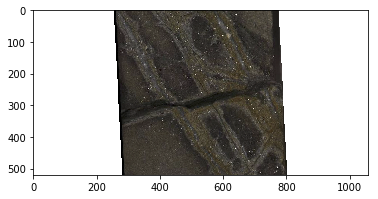

In [413]:
print(image_id)
# img = imageio.imread('output/images/' + image_id)
img = imageio.imread('/home/dkpun/geo_solution/jupyter-notebooks/MaskRCNN-utils/augmentor/output/mrcnn/rock-7.pngc75b30d01ab14d3ab840adaced9c2a01.png_e794da7e-f634-4273-b546-f808b93e5c9a.png/images/rock-7.pngc75b30d01ab14d3ab840adaced9c2a01.png_e794da7e-f634-4273-b546-f808b93e5c9a.png')
plt.imshow(img)

rock-7.pngcf0c88ce4c3d49e98d801e46b5eb23d4.png


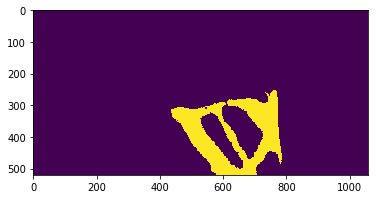

In [414]:
print(image_id)
# img = imageio.imread('output/masks/' + image_id)
img = imageio.imread('/home/dkpun/geo_solution/jupyter-notebooks/MaskRCNN-utils/augmentor/output/mrcnn/rock-7.pngc75b30d01ab14d3ab840adaced9c2a01.png_e794da7e-f634-4273-b546-f808b93e5c9a.png/masks/rock-7.pngc75b30d01ab14d3ab840adaced9c2a01.png_e794da7e-f634-4273-b546-f808b93e5c9a.png')
plt.imshow(img)